Import required Python libraries

In [1]:
import scipy.io
import numpy as np
import operator as op

Import and configure matplotlib for plotting

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt # matplotlib
matplotlib.rcParams['figure.figsize'] = list(map(lambda x: 2*x, matplotlib.rcParams['figure.figsize']))
matplotlib.style.use('ggplot')

Define data container for MSI experiments

In [3]:
"""
Data container for MSI measurements
"""
class MSIData(object):
    def __init__(self, data_matrix, mz_values, row2grid, nonnull_spots):
        self._data = data_matrix
        self._mz_values = mz_values.flatten()
        self._mz_dict = {mz: index for index, mz in enumerate(mz_values.flatten())}
        self._row2grid = row2grid
        self._nonnull_spots = nonnull_spots
    
    @property
    def data(self):
        """"Returns the data matrix."""
        return self._data
    
    @property
    def mz_values(self):
        """"Returns the m/z values that were measured."""
        return self._mz_values
    
    @property
    def row2grid(self):
        """Returns a conversion table of data rows to x/y coordinates."""
        return self._row2grid
    
    @property
    def nonnull_spots(self):
        """Indicates which spots were measured."""
        return self._nonnull_spots
    
    @property
    def mz_dict(self):
        """Returns a dictionnary of m/z values to data row indices."""
        return self._mz_dict
    
    @property
    def y_size(self):
        return max(map(op.itemgetter(0), self.row2grid)) + 1
        
    @property
    def x_size(self):
        return max(map(op.itemgetter(1), self.row2grid)) + 1
    
    @property
    def ndatarows(self):
        """Returns the number of data rows."""
        return self.data.shape[0]
    
    @property
    def ndatacols(self):
        """Returns the number of data columns."""
        return self.data.shape[1]
    
    @property
    def nbins(self):
        return len(self.mz_values)
    
    def colToMatrix(self, col, indices=None):
        """
        Converts data column into matrix.
        
        If col is a subset of rows, indices indicates the corresponding row indices.
        """
        if (indices == None):
            assert (len(col) == self.ndatarows)
            indices = range(self.ndatarows)
        mat = np.zeros((self.y_size, self.x_size))
        for rowidx, val in zip(indices, col):
            row, col = self.row2grid[rowidx]
            mat[row, col] = val
        return mat
    
    def getIonImageByIndex(self, index):
        """Returns the ion image at specified index as a numpy matrix."""
        rows = self.data[:, index]
        return self.colToMatrix(rows)
    
    def getIonImageByMZ(self, mz_value):
        """Returns the ion image at specified m/z value as a numpy matrix.
        
        Throws a KeyError if specified m/z value is not included in this data.
        """
        index = self.mz_dict.get(mz_value, default=None)
        if index is None: 
            raise KeyError("%f not in mz_values" % mz_value)
        else:
            return getIonImageByIndex(index)
    
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, key):
        """Returns the mass spectrometry vector at given data index."""
        return self.data[key, :]
        
    def __str__(self):
        return "MSI data set:\n- x_size: \t %d\n- y_size: \t %d\n- nbins: \t %d" % (self.x_size, self.y_size, self.nbins)
    
    def transpose(self):
        """Returns a new MSI data set that is the transpose of this."""
        transposed_row2grid = np.zeros(self.row2grid.shape, dtype=np.uint32)
        transposed_row2grid[:,0] = self.row2grid[:, 1]
        transposed_row2grid[:,1] = self.row2grid[:, 0]
        return MSIData(data_matrix = self.data,
                       mz_values = self.mz_values,
                       row2grid = transposed_row2grid, 
                       nonnull_spots = self.nonnull_spots)
        

# Load data set

In [4]:
data = scipy.io.loadmat('coronal_lipid_neg_pp.mat')
data.keys()

dict_keys(['x_size', 'grid2row', 'nonnull_spots', '__globals__', 'peak_blc_iec_aligned_mzs', 'ans', '__version__', 'feat_size', 'blc_iec_ms_rows_aligned_pp', 'mz_values', 'row2grid', '__header__', 'original_rows', 'y_size'])

Some statistics about the raw data before encapsulating it in the MSIData container.

In [5]:
rows = data["y_size"][0][0]
cols = data["x_size"][0][0]
bins = data["feat_size"][0][0]
print("rows: %d, cols: %d, m/z bins %d" % (rows, cols, bins))

mz_values = data["mz_values"]
feat_size = data["feat_size"]
row2grid = data["row2grid"]
grid2row = data["grid2row"]
nonnull_spots = data["nonnull_spots"]

data_matrix = data["blc_iec_ms_rows_aligned_pp"]

rows: 77, cols: 127, m/z bins 26624


In [6]:
msi_data = MSIData(data_matrix = data_matrix, 
                   mz_values = mz_values, 
                   row2grid = row2grid.astype(np.int32) - 1,  # matlab indexing is 1-based, python is 0-based
                   nonnull_spots = nonnull_spots)
print(msi_data)

MSI data set:
- x_size: 	 77
- y_size: 	 127
- nbins: 	 26624


Lambda function to plot an ion image based on an MSIData object and mass bin index.

In [7]:
plotIonImg = lambda data, index: plt.imshow(data.getIonImageByIndex(index))

In [8]:
msi_data_transp = msi_data.transpose()
print(msi_data_transp)

MSI data set:
- x_size: 	 127
- y_size: 	 77
- nbins: 	 26624


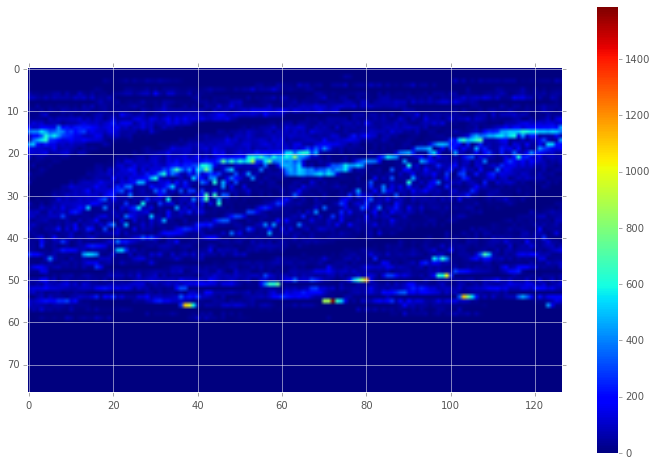

In [9]:
label_bin = 598
plotIonImg(msi_data_transp, label_bin)
plt.colorbar()
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import preprocessing

see data

In [11]:
X = data_matrix
print(X)
X.shape

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


(7625, 792)

After pre_processing and peak picking, use support vector machine
labling: pick a m/z value. create labels by defining a threshold for one specific m/z bin (molecule) e.g.choose m/z = 325

# Labelling

(array([  2.42800000e+03,   1.14400000e+03,   9.69000000e+02,
          7.05000000e+02,   5.37000000e+02,   3.62000000e+02,
          2.68000000e+02,   1.89000000e+02,   1.50000000e+02,
          1.23000000e+02,   8.90000000e+01,   7.40000000e+01,
          6.00000000e+01,   5.40000000e+01,   4.50000000e+01,
          4.10000000e+01,   2.60000000e+01,   2.80000000e+01,
          2.00000000e+01,   1.60000000e+01,   2.20000000e+01,
          1.50000000e+01,   1.70000000e+01,   2.30000000e+01,
          9.00000000e+00,   1.90000000e+01,   1.20000000e+01,
          2.30000000e+01,   2.00000000e+01,   1.80000000e+01,
          1.00000000e+01,   1.10000000e+01,   7.00000000e+00,
          9.00000000e+00,   1.10000000e+01,   1.30000000e+01,
          6.00000000e+00,   7.00000000e+00,   1.00000000e+01,
          6.00000000e+00,   6.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
        

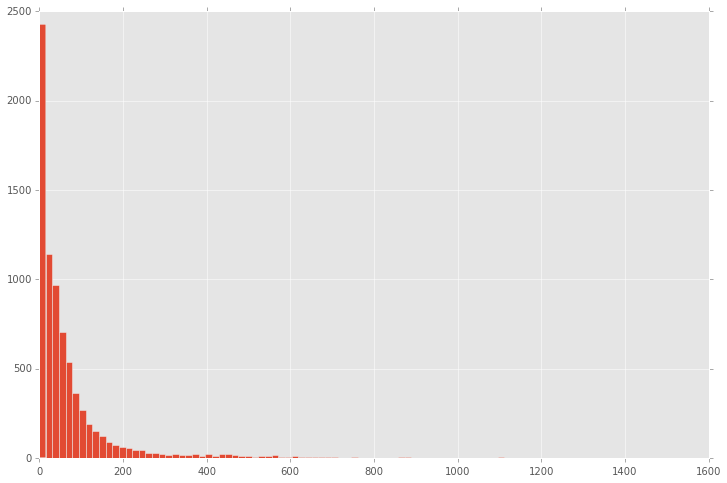

In [12]:
Y=X[:, label_bin]
plt.hist(Y, bins=100)

In [13]:
threshold = 300
binarizer = preprocessing.Binarizer(threshold=threshold)
X_L=binarizer.transform(Y)
y1=X_L.T
y1.shape
npos = np.sum(y1)
print("%d positives, %d negatives" % (npos, y1.shape[0]-npos))

315 positives, 7310 negatives


/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


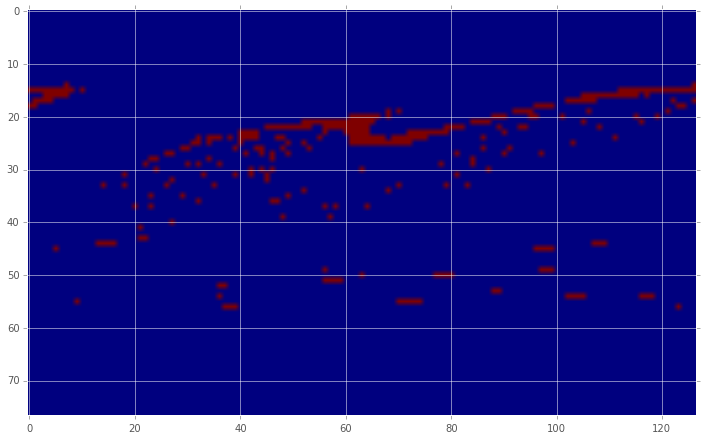

In [14]:
labelplot = msi_data_transp.getIonImageByIndex(label_bin) > threshold
plt.imshow(labelplot)

In [15]:
c,r=y1.shape
y=y1.reshape(c,)
y.shape

(7625,)

In [16]:
exclusion = set(range(label_bin - 10, label_bin + 10))
X_new = X[:, np.array([not i in exclusion for i in range(X.shape[1])])]
#X_new = X[:, np.arange(X.shape[1]) != label_bin]
X_new.shape

(7625, 772)

# SVM

In [17]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
import optunity
import optunity.metrics
import optunity.cross_validation

Code to run nested cross-validation experiment, which involves
- outer cross-validation: 2 folds, returns list of (auc, predictions) per fold
- inner cross-validation: tuning hyperparameters (using 2x3 fold cv)

In [18]:
# extend data matrix to include spatial location of pixels in first 2 cols
colidxs, rowidxs = zip(*map(lambda row: msi_data_transp.row2grid[row], range(X_new.shape[0])))
tocol = lambda lst: np.array(lst, ndmin=2).transpose()
data = np.hstack((tocol(rowidxs), tocol(colidxs), X_new))
labels = y

@optunity.cross_validated(x=data, y=labels, num_folds=2,
                         aggregator=optunity.cross_validation.identity)
def nested_cv(x_train, y_train, x_test, y_test):

    # extract spatial location of pixels (first 2 cols)
    x_train = x_train[:, 2:]
    rows = x_test[:, 0]
    cols = x_test[:, 1]
    x_test = x_test[:, 2:]
    
    # inner cross-validation to estimate performance of a set of hyperparameters
    @optunity.cross_validated(x=x_train, y=y_train, num_folds=3, num_iter=2)
    def inner_cv(x_train, y_train, x_test, y_test, C):
        model = LinearSVC(C=C).fit(x_train, y_train)
        predictions = model.decision_function(x_test)
        return optunity.metrics.roc_auc(y_test, predictions)

    hpars, info, _ = optunity.maximize(inner_cv, num_evals=20, C=[0, 10])
    print('')
    print('Hyperparameters: ' + str(hpars))
    print('Cross-validated AUROC after tuning: %1.3f' % info.optimum)
    model = LinearSVC(**hpars).fit(x_train, y_train)
    predictions = model.decision_function(x_test)
    auc = optunity.metrics.roc_auc(y_test, predictions)    
    return (auc, np.vstack((rows, cols, predictions)))

## Run nested cross-validation procedure and retain results

In [19]:
res = nested_cv()
mean_roc_auc = sum(map(op.itemgetter(0), res)) / len(res)
print('Mean area under ROC curve in outer cross-validation: %1.3f' % mean_roc_auc)


Hyperparameters: {'C': 1.103515625}
Cross-validated AUROC after tuning: 0.994

Hyperparameters: {'C': 9.92581128371551}
Cross-validated AUROC after tuning: 0.989
Mean area under ROC curve in outer cross-validation: 0.990


### Construct matrix of (out-of-sample) predictions for each pixel.

In [22]:
predictions = np.hstack(map(op.itemgetter(1), res))
prediction_matrix = np.zeros((msi_data_transp.y_size, msi_data_transp.x_size))
for i in range(predictions.shape[1]):
    row = predictions[0, i]
    col = predictions[1, i]
    val = predictions[2, i]
    prediction_matrix[col, row] = val

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Plot predictions heatmap

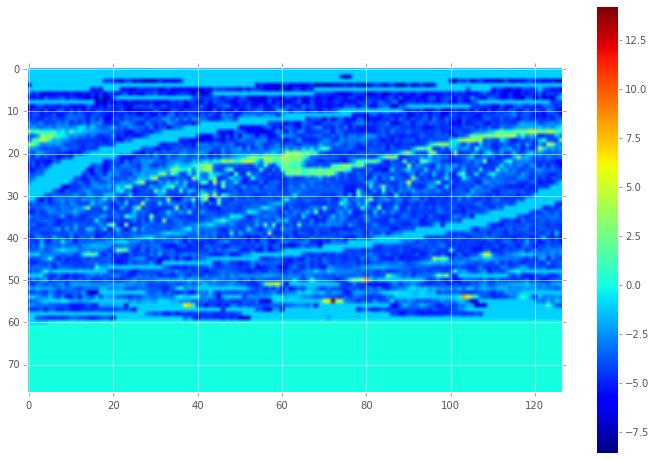

In [23]:
plt.imshow(prediction_matrix)
# plt.imshow(prediction_matrix > 0) # default svm treshold
plt.colorbar()